<a href="https://colab.research.google.com/github/MrtGrd/LEO-satellite-MU-Massive-MIMO/blob/main/DoA_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

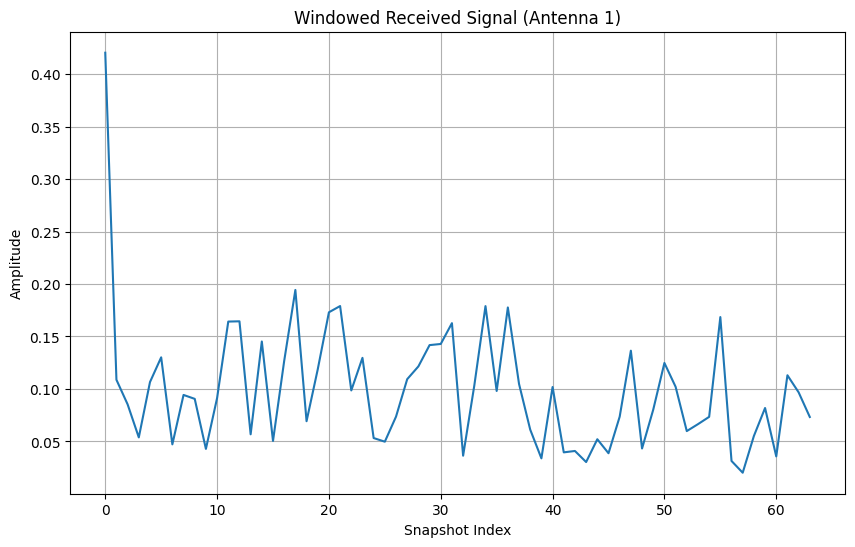

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Parameters
N_x, N_y = 8, 8  # Antenna array dimensions
N = N_x * N_y   # Total number of elements in the array
d = 0.5  # Element spacing (in wavelengths)
sigma_n2 = 0.05  # Noise variance ; SNR= 13 dB
snapshots = 4000
# Input DOAs manually (azimuth and elevation angles in degrees)
doas = [
    {"azimuth": 15, "elevation": 25},   # First source
    {"azimuth": -20, "elevation": 30},  # Second source
    {"azimuth": 30, "elevation": -15},
    {"azimuth": -35, "elevation": -20},
    {"azimuth": 10, "elevation": -30},
    {"azimuth": -25, "elevation": 40},
    {"azimuth": 45, "elevation": 10},
    {"azimuth": -40, "elevation": -10},
    {"azimuth": 20, "elevation": -40},
    {"azimuth": -10, "elevation": 15}   # Last source
]

def generate_random_doas(M, azimuth_fov=30, elevation_fov=30):
    angle_pairs = []
    doas = []
    for _ in range(M):
        azimuth = int(np.random.uniform(-azimuth_fov, azimuth_fov))  # Random azimuth within range
        elevation = int(np.random.uniform(-elevation_fov, elevation_fov))  # Random elevation within range
        doas.append({"azimuth": azimuth, "elevation": elevation})
        angle_pairs.append(f"({azimuth}, {elevation})")
    print("Generated DOAs:", ", ".join(angle_pairs))
    return doas

#doas = generate_random_doas(10, azimuth_fov=30, elevation_fov=30)  #####################################

# Extract DOA information
theta_deg = np.array([doa["azimuth"] for doa in doas])
phi_deg = np.array([doa["elevation"] for doa in doas])
M = len(doas)  # Number of sources

# Convert angles to radians
theta_rad = np.deg2rad(theta_deg)
phi_rad = np.deg2rad(phi_deg)

# Generate steering vector for the URA
def steering_vector(theta, phi, N_x, N_y, d):
    k = 2 * np.pi  # Wavenumber
    x = np.arange(N_x) * d - (N_x - 1) * d / 2  # Centered coordinates in x
    y = np.arange(N_y) * d - (N_y - 1) * d / 2  # Centered coordinates in y
    X, Y = np.meshgrid(x, y)
    X = X.flatten()
    Y = Y.flatten()
    # Steering vector calculation
    sv = np.exp(1j * k * (X * np.cos(phi) * np.sin(theta) + Y * np.sin(phi)))
    return sv / np.sqrt(N_x * N_y)  # Normalize by array size

# Simulate received signal and covariance matrix
def simulate_signal(theta_rad, phi_rad, M, sigma_n2):
    A = np.column_stack([steering_vector(theta, phi, N_x, N_y, d) for theta, phi in zip(theta_rad, phi_rad)])
    S = np.random.randn(M, snapshots) + 1j * np.random.randn(M, snapshots)  # Random complex sources
    X = A @ S + np.sqrt(sigma_n2) * (np.random.randn(N, snapshots) + 1j * np.random.randn(N, snapshots))  # Received signal

    # Apply Hamming window to each column (signal snapshot)
    window = np.hamming(snapshots)  # Hamming window of size equal to snapshots
    X_windowed = X * window  # Element-wise multiplication to apply window

    R = X @ X.conj().T / X.shape[1]  # Sample covariance matrix
    return R, A

R, A = simulate_signal(theta_rad, phi_rad, M, sigma_n2)
# Plot the windowed received signal for one antenna (as an example)
plt.figure(figsize=(10, 6))
plt.plot(np.abs(R[0, :]))  # Plot the absolute value of the signal (after windowing)
plt.title("Windowed Received Signal (Antenna 1)")
plt.xlabel("Snapshot Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.size'] = 10  # Base font size
mpl.rcParams['axes.titlesize'] = 12  # Title font size
mpl.rcParams['axes.labelsize'] = 10  # Axis label font size
mpl.rcParams['xtick.labelsize'] = 8  # X-axis tick label size
mpl.rcParams['ytick.labelsize'] = 8  # Y-axis tick label size
mpl.rcParams['legend.fontsize'] = 8  # Legend font size

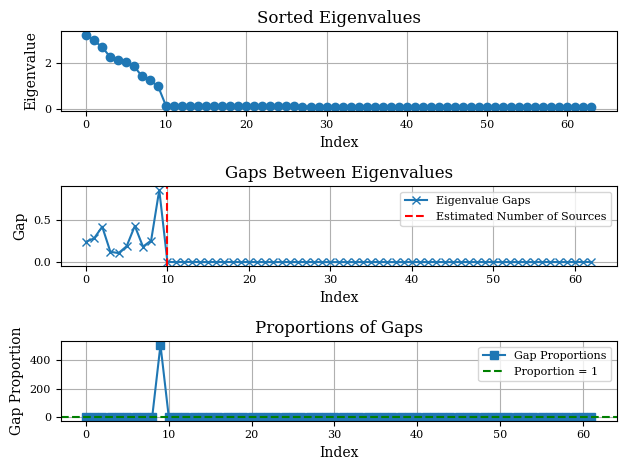

Estimated number of sources: 10


In [ ]:

def estimate_number_of_sources_gap(R):
    # Compute eigenvalues
    eigenvalues = np.linalg.eigvalsh(R)
    eigenvalues = np.flip(np.sort(np.abs(eigenvalues)))  # Sort in descending order

    # Compute gaps between successive eigenvalues
    gaps = (-1)*np.diff(eigenvalues)
    gap_proportions = gaps[:-1] / gaps[1:]
    M_estimated = np.argmax(gap_proportions) + 1

    # Plot sorted eigenvalues
    plt.subplot(3, 1, 1)
    plt.plot(eigenvalues, marker='o', label='Eigenvalues')
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.title('Sorted Eigenvalues')
    plt.grid(True)

    # Plot gaps between eigenvalues
    plt.subplot(3, 1, 2)
    plt.plot(gaps, marker='x', label='Eigenvalue Gaps')
    plt.xlabel('Index')
    plt.ylabel('Gap')
    plt.title('Gaps Between Eigenvalues')
    plt.axvline(x=M_estimated, color='r', linestyle='--', label='Estimated Number of Sources')
    plt.legend()
    plt.grid(True)

    # Plot gap proportions
    plt.subplot(3, 1, 3)
    plt.plot(gap_proportions, marker='s', label='Gap Proportions')
    plt.xlabel('Index')
    plt.ylabel('Gap Proportion')
    plt.title('Proportions of Gaps')
    plt.axhline(y=1, color='g', linestyle='--', label='Proportion = 1')
    plt.legend()
    plt.grid(True)

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

    return M_estimated

# Test the hybrid approach
R = np.random.randn(64, 64)  # Example covariance matrix

# Run simulation
R, A = simulate_signal(theta_rad, phi_rad, M, sigma_n2)

M_estimated = estimate_number_of_sources_gap(R)

print(f"Estimated number of sources: {M_estimated}")


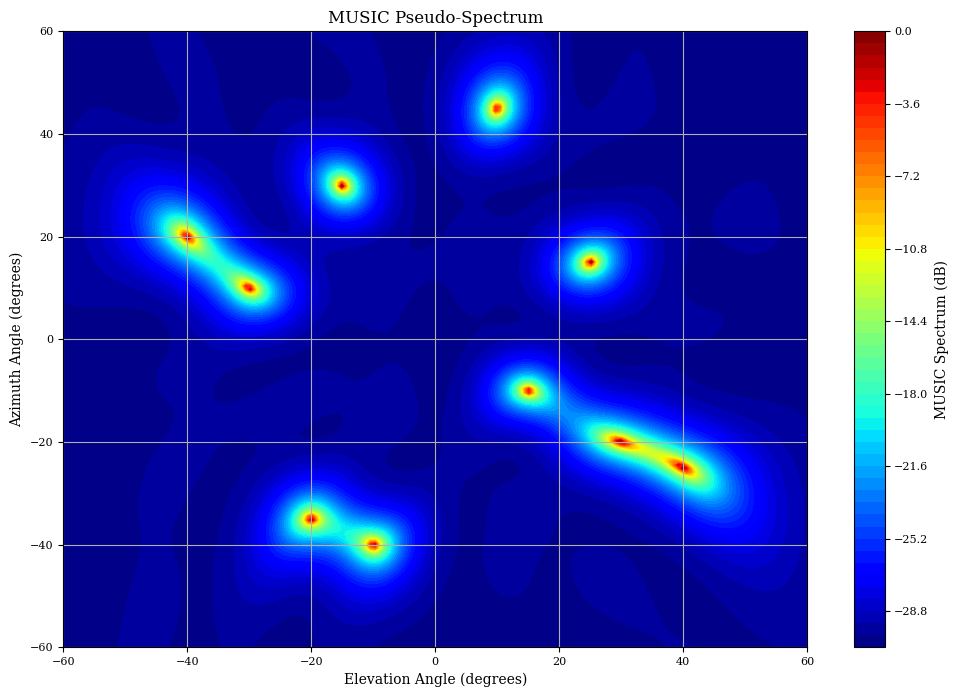

In [ ]:

# MUSIC pseudo-spectrum calculation
def music_spectrum(R, N_x, N_y, d, M_estimated):
    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(R)

    # Noise subspace (eigenvectors associated with smallest eigenvalues)
    E_n = eigvecs[:, :-M_estimated]

    # Define limited scan range
    theta_scan = np.linspace(-60, 60, 180)  # Azimuth angles (-30 to 30 degrees)
    phi_scan = np.linspace(-60, 60, 180)    # Elevation angles (-30 to 30 degrees)
    P_music = np.zeros((len(theta_scan), len(phi_scan)))

    # MUSIC pseudo-spectrum
    for i, theta in enumerate(np.deg2rad(theta_scan)):
        for j, phi in enumerate(np.deg2rad(phi_scan)):
            a = steering_vector(theta, phi, N_x, N_y, d)
            P_music[i, j] = 1 / np.real(a.conj().T @ (E_n @ E_n.conj().T) @ a)

    return 10 * np.log10(P_music / np.max(P_music)), theta_scan, phi_scan

# Compute MUSIC spectrum
P_music, theta_scan, phi_scan = music_spectrum(R, N_x, N_y, d, M_estimated)

# Plot the spectrum
plt.figure(figsize=(12, 8))
plt.contourf(phi_scan, theta_scan, P_music, levels=50, cmap='jet')
plt.colorbar(label='MUSIC Spectrum (dB)')
plt.xlabel('Elevation Angle (degrees)')
plt.ylabel('Azimuth Angle (degrees)')
plt.title('MUSIC Pseudo-Spectrum')
plt.grid(True)
plt.show()


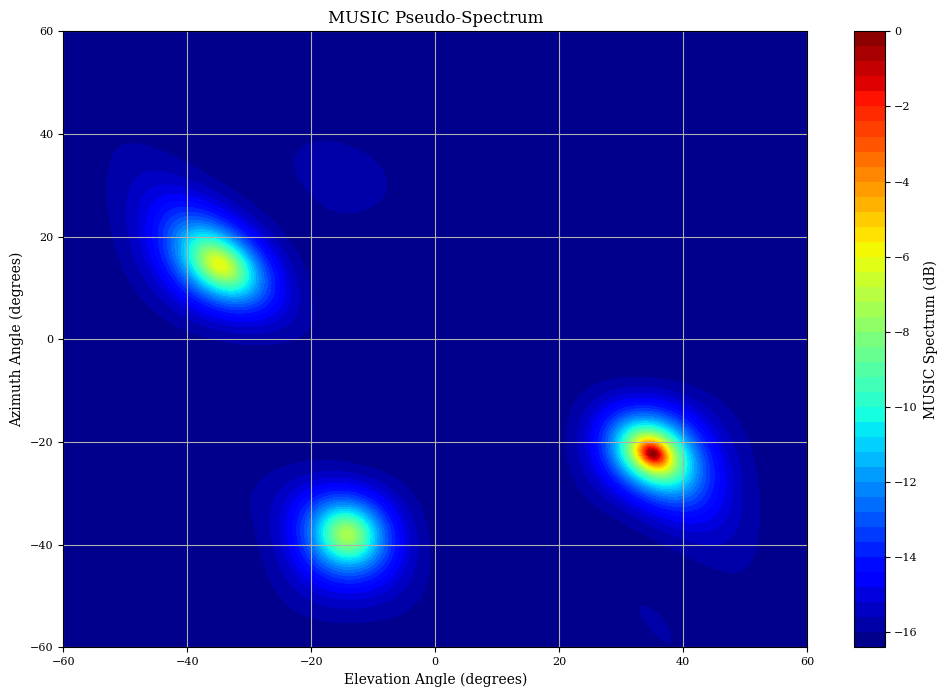

In [ ]:
M_estimated = 3
# MUSIC pseudo-spectrum calculation
def music_spectrum(R, N_x, N_y, d, M_estimated):
    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(R)

    # Noise subspace (eigenvectors associated with smallest eigenvalues)
    E_n = eigvecs[:, :-M_estimated]

    # Define limited scan range
    theta_scan = np.linspace(-60, 60, 180)
    phi_scan = np.linspace(-60, 60, 180)
    P_music = np.zeros((len(theta_scan), len(phi_scan)))

    # MUSIC pseudo-spectrum
    for i, theta in enumerate(np.deg2rad(theta_scan)):
        for j, phi in enumerate(np.deg2rad(phi_scan)):
            a = steering_vector(theta, phi, N_x, N_y, d)
            P_music[i, j] = 1 / np.real(a.conj().T @ (E_n @ E_n.conj().T) @ a)

    return 10 * np.log10(P_music / np.max(P_music)), theta_scan, phi_scan

# Compute MUSIC spectrum
P_music, theta_scan, phi_scan = music_spectrum(R, N_x, N_y, d, M_estimated)

# Plot the spectrum
plt.figure(figsize=(12, 8))
plt.contourf(phi_scan, theta_scan, P_music, levels=50, cmap='jet')
plt.colorbar(label='MUSIC Spectrum (dB)')
plt.xlabel('Elevation Angle (degrees)')
plt.ylabel('Azimuth Angle (degrees)')
plt.title('MUSIC Pseudo-Spectrum')
plt.grid(True)
plt.show()

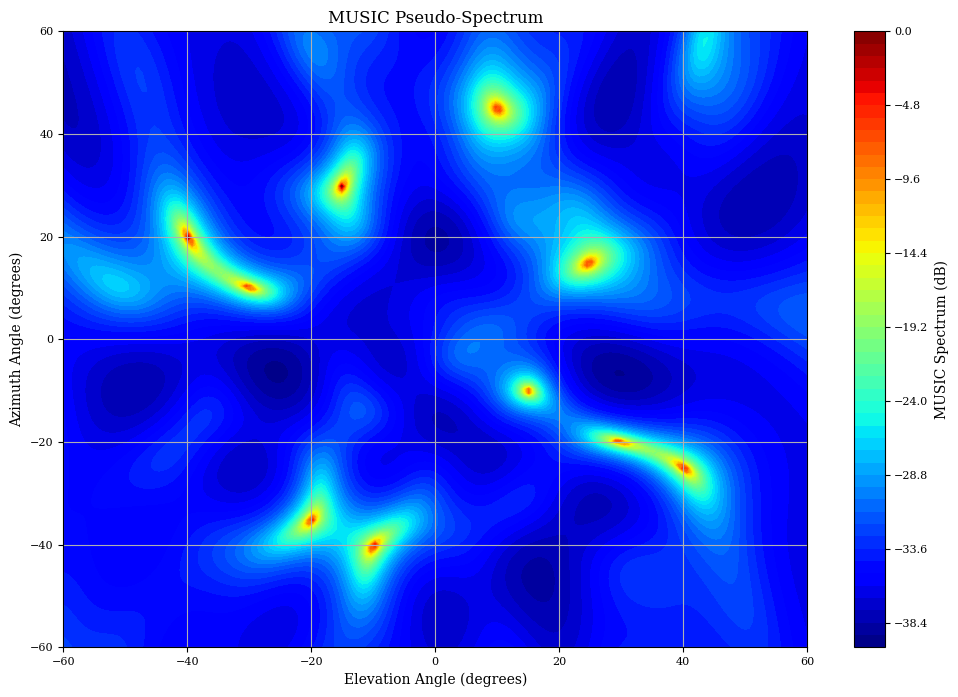

In [ ]:
M_estimated = 60
# MUSIC pseudo-spectrum calculation
def music_spectrum(R, N_x, N_y, d, M_estimated):
    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(R)

    # Noise subspace (eigenvectors associated with smallest eigenvalues)
    E_n = eigvecs[:, :-M_estimated]

    # Define limited scan range
    theta_scan = np.linspace(-60, 60, 180)  # Azimuth angles (-30 to 30 degrees)
    phi_scan = np.linspace(-60, 60, 180)    # Elevation angles (-30 to 30 degrees)
    P_music = np.zeros((len(theta_scan), len(phi_scan)))

    # MUSIC pseudo-spectrum
    for i, theta in enumerate(np.deg2rad(theta_scan)):
        for j, phi in enumerate(np.deg2rad(phi_scan)):
            a = steering_vector(theta, phi, N_x, N_y, d)
            P_music[i, j] = 1 / np.real(a.conj().T @ (E_n @ E_n.conj().T) @ a)

    return 10 * np.log10(P_music / np.max(P_music)), theta_scan, phi_scan

# Compute MUSIC spectrum
P_music, theta_scan, phi_scan = music_spectrum(R, N_x, N_y, d, M_estimated)

# Plot the spectrum
plt.figure(figsize=(12, 8))
plt.contourf(phi_scan, theta_scan, P_music, levels=50, cmap='jet')
plt.colorbar(label='MUSIC Spectrum (dB)')
plt.xlabel('Elevation Angle (degrees)')
plt.ylabel('Azimuth Angle (degrees)')
plt.title('MUSIC Pseudo-Spectrum')
plt.grid(True)
plt.show()

In [ ]:
from google.colab import auth
auth.authenticate_user()
import git
import os

# Set your GitHub username and email (needed for committing changes)
os.system("git config --global user.name MrtGrd")
os.system("git config --global user.email 'a.moh.kh@gmail.com'")

!git clone https://github.com/MrtGrd/DoA.git

!cp -r /content/my_project/* /content/your-repository/